In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# Add the work folder shared with you into your My Drive by adding it as a shortcut before running this cell
%cd gdrive/MyDrive/work

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gold Code Generator

This code takes in a satellite ID and returns its goldcode.

Reference: https://natronics.github.io/blag/2014/gps-prn/

In [2]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

def shift(register, feedback, output):
    """GPS Shift Register

    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:

    """

    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]

    fb = sum([register[i-1] for i in feedback]) % 2

    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]

    register[0] = fb

    return out

def PRN(sv):

    """Build the CA code (PRN) for a given satellite ID

    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite

    """

    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here

    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table

        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca

# Inverse GPS Signal Generator

This block of code loads the output tracking data generated by gnss-sdr and takes the I value from it and multiplies it with the gold code of that satellite, upsamples it and returns it

In [3]:

def gpssignalgen(filepath):
    chkdat = np.fromfile(filepath,dtype = np.short)
    sv = chkdat[14]
    chkdat = chkdat[12::16]
    chkdat = chkdat*(-1*chkdat[0])

    sat_20 = [-1 if x==0 else x for x in PRN(sv)]
    sat_20_upsample = []
    n = 0

    # Upsample
    for i in range(4000):
      if ((i+1)/4000 <= (n+1)/1023):
        sat_20_upsample.append(sat_20[n])
      else:
        n = n+1
        sat_20_upsample.append(sat_20[n])
    gpssignal = []

    # print(sat_20[0:100])
    # print(len(sat_20))
    # print(len(chkdat[1:]))
    i = 0
    # for item in chkdat[1:]:
    #     for j in range(20):
    #         for i in sat_20:
    #             gpssignal.append(item*i)
    # print(len(gpssignal))
    gpssignal1 = []
    chkdat_repeated = np.repeat(chkdat[1:], 20*(len(sat_20_upsample)))
    sat_20_tiled = np.tile(sat_20_upsample, 20*len(chkdat[1:]))
    gpssignal1 = chkdat_repeated * sat_20_tiled
    return gpssignal1

# print(len(gpssignal1))
# if np.array_equal(gpssignal,gpssignal1):
#     print('True')
# np.savetxt('sat_20_data.txt',gpssignal1)

# Load Data
Here we have loaded the output tracking data into `gpssignal`.
Also we have loaded the input GNSS signal data into `data`. After that we are unpacking these into binary data

Note: The input GNSS data we are loading has been split into two as loading the entire file exhausts the RAM of Google Colab, forcing it to restart

In [ ]:
gpssignal = gpssignalgen(filepath = 'telemetry/mydata2.dat')[:4000]
print(len(gpssignal))
# data = np.fromfile('data_split/mydataa', dtype=np.short); #this is the measured samples from gnss-sdr as int16
data = np.fromfile('/home/joel/gps-sdr-sim-master/gpsgen_05092024.dat', dtype=np.short)

# Data Processing

Here we convert the raw data into I + jQ format, and also take care of the doppler shift in the gpssignal generated in the previous block

In [16]:
compdata = data[::2] + (1j)*data[1::2]; # complex samples as (I+jQ)
doppler = 8234.712  # Doppler in hz for satellite 20
doppler2 = 8000
print(len(compdata))
gpssignal_shifted = np.multiply(gpssignal, np.exp(2j*np.pi*doppler*np.arange(len(gpssignal))/4000000))
print(len(gpssignal_shifted))
gpssignal_shifted2 = np.multiply(gpssignal, np.exp(2j*np.pi*doppler2*np.arange(len(gpssignal))/4000000))


200000000
80000


# Correlation Plot

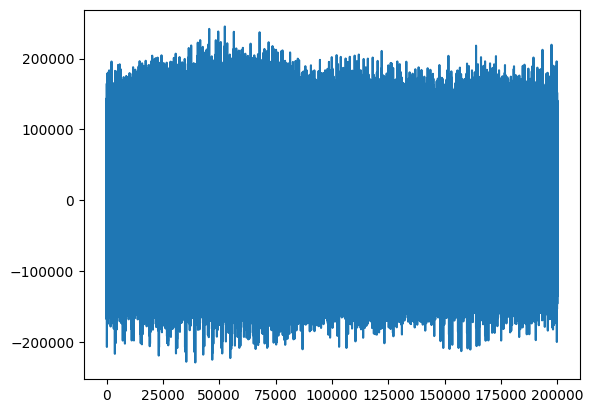

In [17]:
plt.plot(np.correlate(compdata[0:280000], gpssignal))

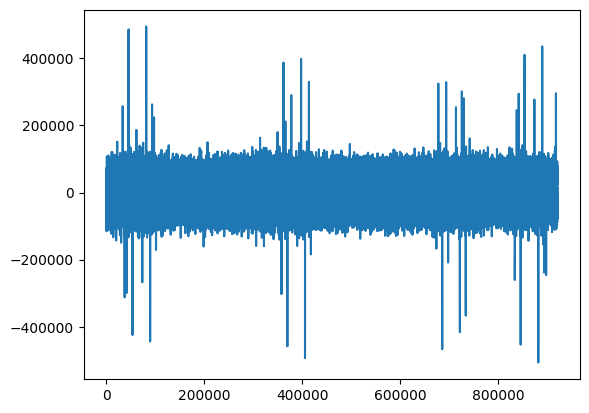

In [25]:
plt.plot(np.correlate(compdata[2200000:3200000], gpssignal_shifted))
# plt.plot(np.correlate(compdata[0:500000], gpssignal_shifted2[:20*4000]));


## Brute Force Search to get Doppler

In [10]:
correlationarray = np.correlate(compdata[0:500000], gpssignal_shifted)

In [12]:
frequencylist = []
for i in range(0,10000,500):
  doppler2 = i
  gpssignal_shifted = np.multiply(gpssignal, np.exp(2j*np.pi*doppler2*np.arange(len(gpssignal))/4000000))
  correlationarray = np.correlate(compdata[0:500000], gpssignal_shifted)
  for j in range(len(correlationarray)):
    maxval = 250000
    if(correlationarray[j]>maxval):
      print(correlationarray[j])
      frequencylist.append(doppler2)
      break
print(frequencylist)

(255103.30912144002+34288.372632091945j)
(252659.51364174896+23504.770616411628j)
(263341.5612388813-89260.81297588888j)
(260858.93633221107-24798.960833184145j)
(270694.9884101839+42463.06712839935j)
[1000, 5000, 7000, 8000, 9000]
